# 302.3. Derived stellar properties

<div style="max-width:300px; float: left; margin-right: 1em">

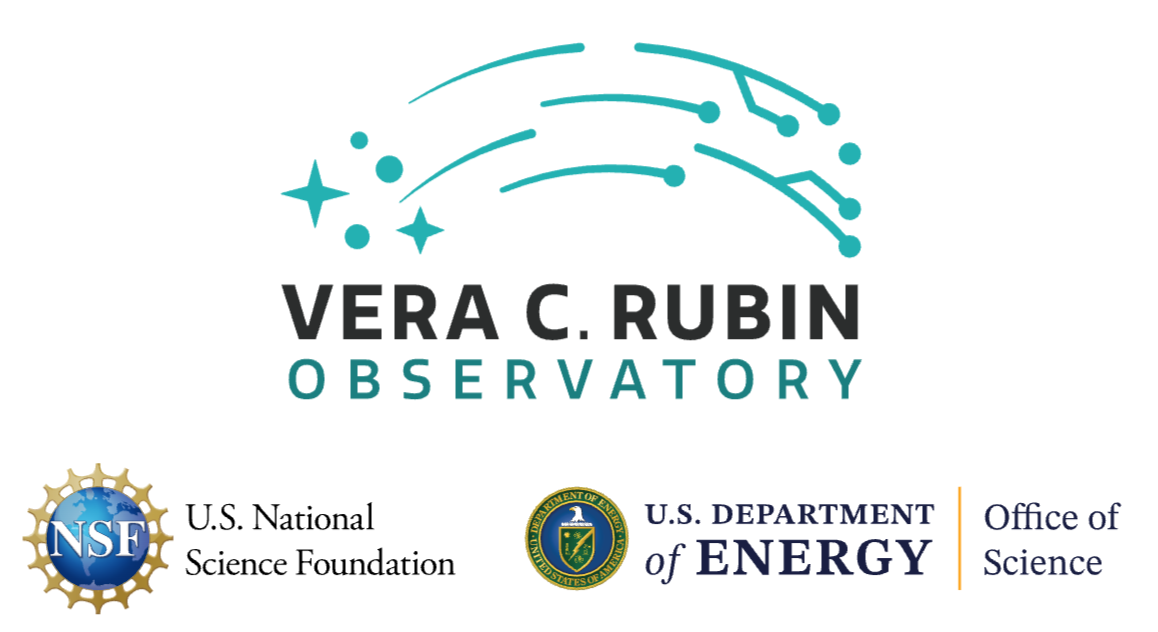

</div>

For the Rubin Science Platform at data.lsst.cloud. <br>
Data Release: <a href="https://dp1.lsst.io">Data Preview 1</a> <br>
Container Size: large <br>
LSST Science Pipelines version: r29.2.0 <br>
Last verified to run: 2026-02-17 <br>
Repository: <a href="https://github.com/lsst/tutorial-notebooks">github.com/lsst/tutorial-notebooks</a> <br>
DOI: <a href="https://doi.org/10.11578/rubin/dc.20250909.20">10.11578/rubin/dc.20250909.20</a> <br>

**Learning objective:** To learn how to derive effective temperature and metallicity for main-sequence stars using their photometry.

**LSST data products:** `Object`

**Packages:** `lsst.rsp.get_tap_service`

**Credit:**
Originally developed by the Rubin Community Science team. Please consider acknowledging them if this notebook is used for the preparation of journal articles, software releases, or other notebooks. 

**Get Support:**
Everyone is encouraged to ask questions or raise issues in the 
<a href="https://community.lsst.org/c/support">Support Category</a> 
of the Rubin Community Forum.
Rubin staff will respond to all questions posted there.

## 1. Introduction

This notebook demonstrates how to derive effective temperature ($T_{eff}$) and metallicity ([Fe/H]) of F- and G-type main-sequence stars from their $u-g$ and $g-r$ colors, following the methodology developed by [Ivezić et al. (2008)](https://ui.adsabs.harvard.edu/abs/2008ApJ...684..287I/abstract), and examines the metallicity distribution along the $Z$-axis in the Galactic cylindrical coordinate system. 

They used the Sloan Digital Sky Survey (SDSS) spectroscopic sample of ~60,000 F- and G-type dwarfs to calibrate color–parameter relations. They determined the stellar $T_{eff}$ from the $g–r$ color alone, since $T_{eff}$ depends strongly on $g–r$ and only negligibly on $u–g$. They fitted a linear relation between log($T_{eff}$) and $g–r$ to the spectroscopic temperatures, obtaining log($T_{eff}$/[K]) = 3.872 – 0.264$\times$($g–r$), which yields temperatures with about 100 K scatter per star. Then used the correlation between ultraviolet excess and stellar metallicity to estimate [Fe/H]. Decreasing metallicity reduces line blanketing in the blue and ultraviolet, making $u–g$ bluer at fixed $g–r$. They modeled the median metallicity across the ($u–g$, $g–r$) plane with a cubic polynomial surface: [Fe/H] = A + B$x$ + C$y$ + D$xy$ + E$x²$ + F$y²$ + G$x²y$ + H$xy²$ + I$x³$ + J$y³$, where $x$ = $u–g$ for $g–r$ ≤ 0.4 and $x$ = ($u–g$) – 2$\times$($g–r$) + 0.8 for $g–r$ > 0.4, $y$ = $g–r$, and A–J are empirically fitted constants: (A-J) = (-4.37; -8.56; 15.5; -39.0; 23.5; 20.5; 12.1; 7.33; -10.1; -21.4). 

<div style="max-width:600px">

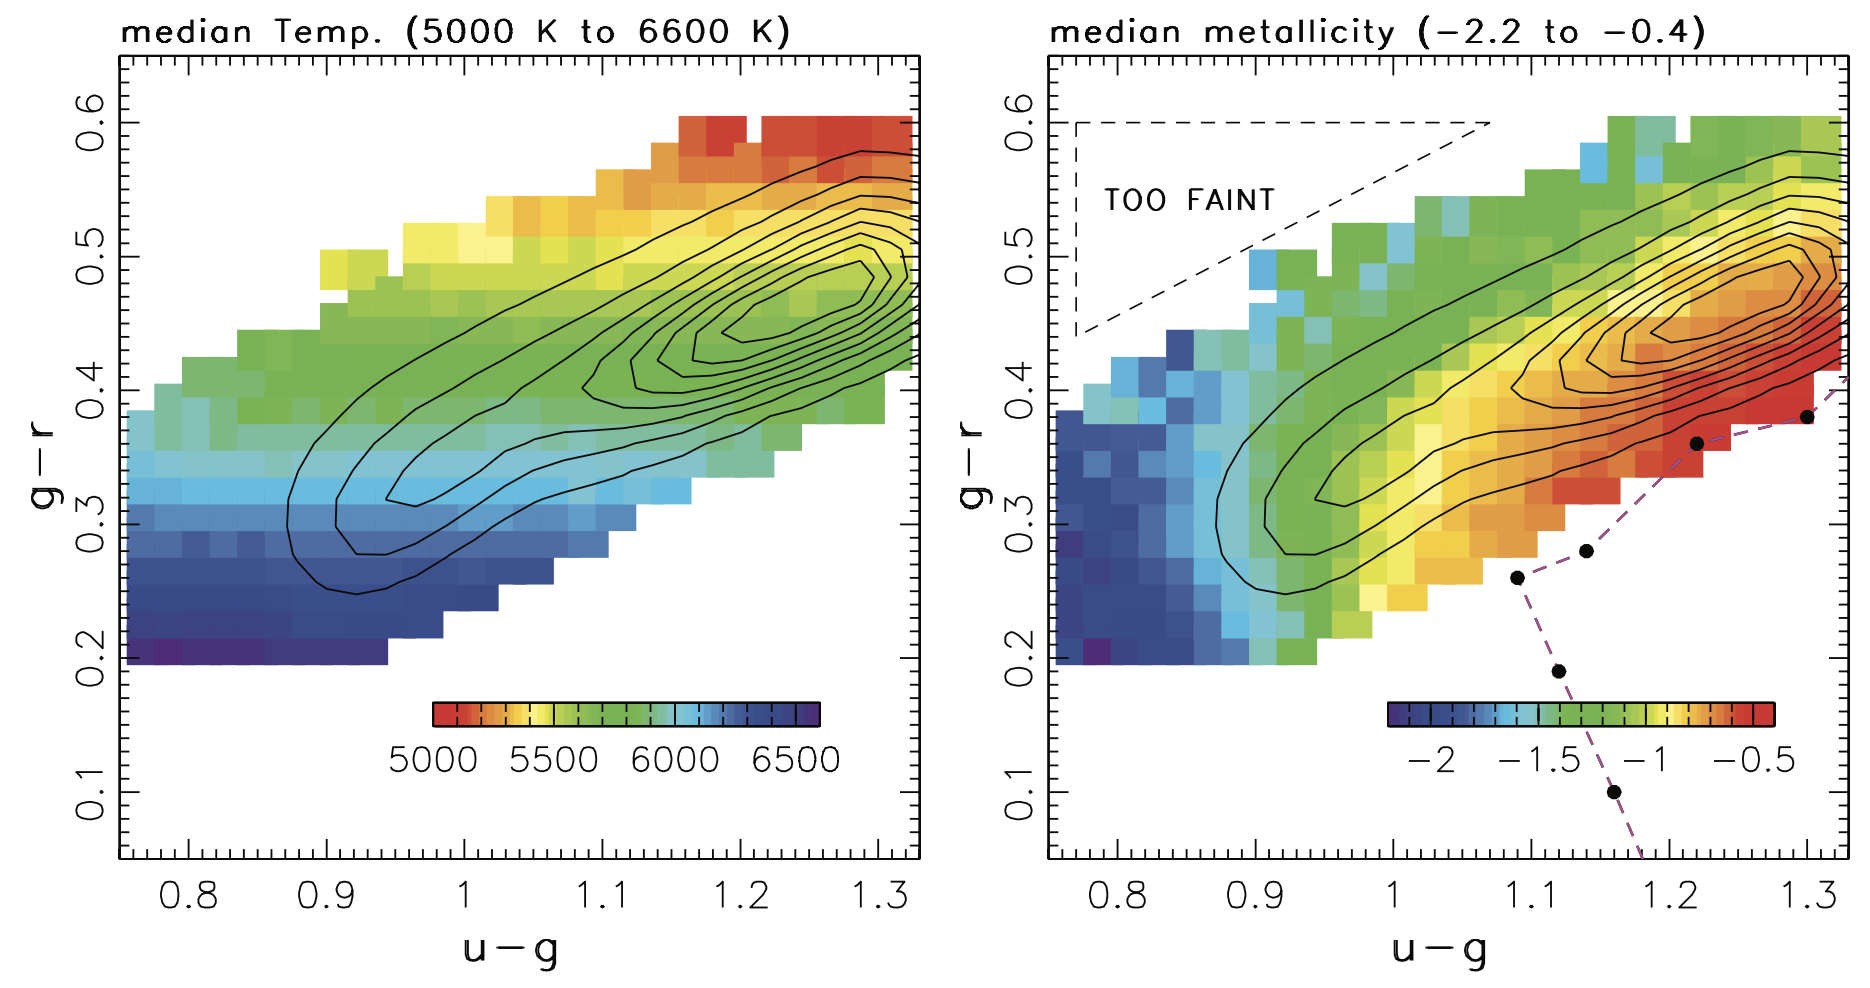

</div>

> **Figure 1:** The figure is adopted from [Ivezić et al. (2008)](https://ui.adsabs.harvard.edu/abs/2008ApJ...684..287I/abstract), showing spectroscopically derived $T_{eff}$ (left) and [Fe/H] (right) on the $g-r$ versus $u-g$ color-color plane. 

This notebook converts photometry from the Rubin's ComCam system to SDSS system and applies these calibrated relations to photometric data for F- and G-type main-sequence stars with 0.2 < $g–r$ < 0.6 to infer $T_{eff}$ and [Fe/H]. The expected precision is ∼100 K in temperature and ∼0.2 dex in metallicity, limited mainly by $u$-band photometric errors.

**Note:** This tutorial provides a pedagogical framework for illustrating how to handle the DP1 photometry and is not intended to serve as a definitive catalog of stellar parameters. Users should be aware that the derived physical quantities—particularly [Fe/H] and Galactocentric coordinates—are sensitive to systematic uncertainties in distance estimation and interstellar extinction.

**References:** See [Ivezić et al. (2008)](https://ui.adsabs.harvard.edu/abs/2008ApJ...684..287I/abstract) for stellar parameter derivation using their colors, and [RTN-099](https://rtn-099.lsst.io/) for photometric transformation from the Rubin's ComCam photometry to SDSS system.

**Related tutorials:** See the 300-level DP1 tutorial on the Milky Way foreground dust correction.

### 1.1. Import packages

Import `numpy`, a fundamental package for scientific computing with arrays in Python
(<a href="https://numpy.org">numpy.org</a>), 
`matplotlib`, a comprehensive library for data visualization
(<a href="https://matplotlib.org/">matplotlib.org</a>;
<a href="https://matplotlib.org/stable/gallery/index.html">matplotlib gallery</a>), and the `SkyCoord` class from <a href="https://docs.astropy.org/en/stable/coordinates/index.html">astropy.cooridates</a>.

From the LSST pacakge (<a href="https://pipelines.lsst.io/">pipelines.lsst.io</a>), import the RSP Table Access Protocol (TAP) service and the `DustValues` class from the `rubin_sim` package (<a href="https://rubin-sim.lsst.io/index.html">rubin_sim</a>).

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.coordinates import SkyCoord, Galactocentric
import astropy.units as u
import os

from lsst.rsp import get_tap_service
from rubin_sim.phot_utils import DustValues

### 1.2. Define parameters and functions

Create an instance of the TAP service, and assert that it exists.

In [ ]:
service = get_tap_service("tap")
assert service is not None

Define a circular region with a 1-degree radius centered on the "low-latitude field" RubinSV_95_-25. (coordinates in degrees).

In [ ]:
ra_cen = 95.0
dec_cen = -25.0
radius = 1.0

Set the environment variable RUBIN_SIM_DATA_DIR to /rubin/rubin_sim_data to make the current rubin_sim throughput data available.

In [ ]:
os.environ['RUBIN_SIM_DATA_DIR'] = '/rubin/rubin_sim_data'

List bands that are used in this notebook.

In [ ]:
bands = "ugri"

Set font sizes globally for all subsequent matplotlib figures in this notebook.

In [ ]:
plt.rcParams["font.size"] = 15
plt.rcParams["figure.titlesize"] = 15
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["axes.titlesize"] = 12

## 2. Transform ComCam photometry to SDSS photometry

Retrieve the necessary PSF photometry to select stars for which the calibrated relations can be applied, correct for Milky Way foreground dust, and transform the dust-corrected photometry to the SDSS system.

### 2.1. Query for point-like objects

Query the `Object` table in the RbinSV_95_-25 field for coordinates, PSF photometry in $ugri$, and $E(B-V)$ values. Restrict to point sources (`refExtendedness` = 0).

In [ ]:
query = """
        SELECT coord_ra, coord_dec, u_psfMag, g_psfMag, r_psfMag, i_psfMag, ebv
        FROM dp1.Object
        WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec),
              CIRCLE('ICRS', {}, {}, {})) = 1
        AND refExtendedness = 0
        """.format(ra_cen, dec_cen, radius)

In [ ]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)
if job.phase == 'ERROR':
    job.raise_if_error()

Fetch the results, store them as a table.

In [ ]:
assert job.phase == 'COMPLETED'
objtab = job.fetch_result().to_table()

### 2.2. Apply dust correction

The `DustValues().r_x` attribute provides the extinction coefficients for the Rubin filters. These coefficients are derived from the CCM89 extinction law ([Cardelli, Clayton, & Mathis 1989](https://ui.adsabs.harvard.edu/abs/1989ApJ...345..245C/abstract)), assuming a flat spectral energy distribution and a default total-to-selective extinction ratio of 3.1, representative of the diffuse Milky Way interstellar medium.


In [ ]:
R_band = DustValues().r_x

Compute dust extinction in $ugri$ using $A_{\lambda}$ = $R_{\lambda} \times E(B-V)$.

In [ ]:
A_band = {band: R_band[band] * objtab['ebv'] for band in bands}

Apply dust correction in each filter and save the dust-corrected magnitudes as new columns in the `objtab` table.

In [ ]:
for band in bands:
    objtab[f"{band}_psfMag0"] = objtab[f"{band}_psfMag"] - A_band[band]

### 2.3. Convert photometry to SDSS system

First, calculate various stellar colors using dust-corrected magnitudes and store them as arrays for use in subsequent color-color transformation task.

In [ ]:
ug = objtab["u_psfMag0"] - objtab["g_psfMag0"]
gr = objtab["g_psfMag0"] - objtab["r_psfMag0"]
gi = objtab["g_psfMag0"] - objtab["i_psfMag0"]
ri = objtab["r_psfMag0"] - objtab["i_psfMag0"]

Transform the LSSTComCam photometry in $gri$ to the SDSS system, following the equations in Section 1.3.5 of [RTN-099](https://rtn-099.lsst.io/). The valid color range of these transformations is $0.2 < (g-i)_{ComCam} < 3.0$.

In [ ]:
gi_mask = (gi > 0.2) & (gi <= 3.0)

g_sdss = np.where(gi_mask, objtab["g_psfMag0"] + 0.066*gi - 0.006, np.nan)
r_sdss = np.where(gi_mask, objtab["r_psfMag0"] + 0.007*gi - 0.005, np.nan)
i_sdss = np.where(gi_mask, objtab["i_psfMag0"] + 0.012*gi - 0.020, np.nan)

Since LSSTComCam DP1 $u$-band exposures do not overlap with SDSS footprints, utilize synthetic photometry based on the Pickles Stellar Spectra Library ([Pickles 1998](https://iopscience.iop.org/article/10.1086/316197)) to derive the $u$-band transformations. Refer to Section 1.2.3 of [RTN-099](https://rtn-099.lsst.io/) for the detailed derivation and validation of these synthetic coefficients.

In [ ]:
u_masks = [
    (gi > -1.1) & (gi <= -0.4),
    (gi > -0.4) & (gi <= 0.8),
    (gi > 0.8) & (gi <= 3.9)
]
u_outputs = [
    objtab["u_psfMag0"] + 0.587*gi**2 + 1.424*gi + 0.758,
    objtab["u_psfMag0"] + 0.063*gi**2 - 0.192*gi + 0.263,
    objtab["u_psfMag0"] - 0.0003*gi**2 + 0.174*gi + 0.059
]
u_sdss = np.select(u_masks, u_outputs, default=np.nan)

Calculate the required SDSS stellar colors and store them as new arrays for subsequent analysis.

In [ ]:
ug_sdss = u_sdss - g_sdss
gr_sdss = g_sdss - r_sdss
gi_sdss = g_sdss - i_sdss
ri_sdss = r_sdss - i_sdss

### 2.4. Select the main-sequence stars

Select the main-sequence stars for deriving photometric estimates of $T_{eff}$ and [Fe/H], following the sample selection criteria described in [Ivezić et al. (2008)](https://ui.adsabs.harvard.edu/abs/2008ApJ...684..287I/abstract).

In [ ]:
g_cri = (g_sdss > 14) & (g_sdss < 19.5)
gr_cri = (gr_sdss > 0.2) & (gr_sdss < 0.6)
ug_gr_cri = ((ug_sdss > 0.7) & (ug_sdss < 2.0) &
             (gr_sdss - 0.5*ug_sdss > -0.25) & (gr_sdss - 0.5*ug_sdss < 0.05))
gr_ri_cri = (0.35*gr_sdss - ri_sdss > -0.2) & (0.35*gr_sdss - ri_sdss < 0.1)

In [ ]:
sel = (A_band["r"] < 0.3) & g_cri & gr_cri & ug_gr_cri & gr_ri_cri
print(f"There are {len(gr_sdss[sel])} stars suitable for this analysis.")

## 3. Derive stellar parameters

Derive stellar parameters ($T_{eff}$ and [Fe/H]) utilizing the relations described in Introduction.

### 3.1. Stellar effective temperature

Compute $T_{eff}$ using the dust-corrected $g-r$ color for the selected main-sequence stars.

In [ ]:
log_teff = 3.872 - 0.264*(gr_sdss[sel])

Plot the $g-r$ versus $u-g$ color-color diagram with color-coded by the estimated $T_{eff}$.

In [ ]:
plt.scatter(np.ma.filled(ug_sdss[sel], np.nan),
            np.ma.filled(gr_sdss[sel], np.nan),
            c=10**np.ma.filled(log_teff, np.nan), cmap=plt.cm.jet_r)
plt.xlabel('u-g')
plt.ylabel('g-r')
cb = plt.colorbar()
cb.set_label(r'$T_{eff}$ [K]')

> **Figure 2:** Derived stellar effective temperature mapped across the $g-r$ versus $u-g$ color-color diagram. Hotter stars emit more energy at shorter wavelengths, causing their colors to appear bluer.

### 3.2. Stellar metallicity

Define a function to compute [Fe/H] using the dust-corrected $u-g$ and $g-r$ colors for the selected main-sequence stars.

In [ ]:
def feh_phot_ivezic2008(u_minus_g, g_minus_r):
    """
    Compute photometric metallicity [Fe/H]_ph from SDSS colors using the
    calibration of Ivezić et al. (2008, ApJ, 684, 287; Eq. 4).

    This empirical relation estimates stellar metallicity for F/G-type
    main-sequence stars based on their (u–g) and (g–r) colors.

    Parameters
    ----------
    u_minus_g : array_like
        The (u–g) color(s) of the star(s).
    g_minus_r : array_like
        The (g–r) color(s) of the star(s).

    Returns
    -------
    feh : ndarray
        Photometric metallicity [Fe/H]_ph, in dex.
    """
    ug = np.asarray(u_minus_g, dtype=float)
    gr = np.asarray(g_minus_r, dtype=float)

    x = np.where(gr <= 0.4, ug, ug - 2.0*gr + 0.8)
    y = gr

    a, b, c, d, e, f, g, h, i, j = (
        -4.37, -8.56, 15.5, -39.0, 23.5, 20.5, 12.1, 7.33, -10.1, -21.4
    )

    feh = (a + b*x + c*y + d*x*y + e*x**2 + f*y**2
             + g*x**2*y + h*x*y**2 + i*x**3 + j*y**3)

    return feh

Compute [Fe/H] using the dust-corrected $u-g$ and $g-r$ colors.

In [ ]:
feh = feh_phot_ivezic2008(ug_sdss[sel], gr_sdss[sel])

Plot the $g-r$ versus $u-g$ color-color diagram with color-coded by the estimated $T_{eff}$.

In [ ]:
plt.scatter(ug_sdss[sel], gr_sdss[sel], c=feh, cmap=plt.cm.jet)
plt.xlabel('u-g')
plt.ylabel('g-r')
cb = plt.colorbar()
cb.set_label('[Fe/H]')

> **Figure 3:** Derived stellar metallicity mapped across the $g-r$ versus $u-g$ color-color diagram. As stellar metallicity increases, line blanketing strengthens, causing the stellar colors to appear redder.

## 4. Spatial distribution of metallicity  

Derive the $r$-band absolute magnitude via the photometric parallax, compute heliocentric distances from the distance modulus, and convert ICRS positions of the selected stars to Galactocentric coordinates. Examine the [Fe/H] distribution versus Galactocentric radius ($\rho$) and height above the Galactic plane ($Z$) to map the Milky Way’s structure.

**Note:** The field spans a narrow sky region, so spatial leverage is limited and $\rho$ and $Z$ are tightly correlated along the line of sight.


In [ ]:
def mr_phot_ivezic2008(g_minus_i, feh):
    """
    Photometric parallax absolute magnitude M_r per Ivezić et al. (2008).

    Parameters
    ----------
    g_minus_i : array_like
        SDSS (g−i) color(s) of main-sequence stars.
        Typically valid for 0.2 < (g−i) < 4.0.
    feh : array_like
        Stellar metallicity [Fe/H] in dex.
        Valid over roughly −2.5 < [Fe/H] < 0.

    Returns
    -------
    mr : ndarray
        r-band absolute magnitude M_r.
    """
    gi = np.asarray(g_minus_i, dtype=float)
    feh = np.asarray(feh, dtype=float)

    x = gi
    mr0 = -5.06 + 14.32*x - 12.97*x**2 + 6.127*x**3 - 1.267*x**4 + 0.0967*x**5

    delta_mr = 4.50 - 1.11*feh - 0.18*feh**2

    return mr0 + delta_mr

Compute heliocentric distances in kpc from the distance modulus.

In [ ]:
dmod = r_sdss[sel] - mr_phot_ivezic2008(gi_sdss[sel], feh)
dist = 10**(0.2*(dmod+5))/1e3

Two angles and a distance specify a unique point in 3D space, which also allows converting the coordinates to a Cylindrical representation ($\rho$, $\phi$, $Z$) in (kpc, deg, kpc). The conversion assumes a Galactocentric radius of 8.2 kpc for the Sun and a height of 0.025 kpc above the Galactic midplane.

In [ ]:
c = SkyCoord(ra=objtab["coord_ra"][sel], dec=objtab["coord_dec"][sel],
             distance=dist*u.kpc, frame="icrs")

In [ ]:
gc = c.transform_to(Galactocentric(
    galcen_distance=8.2*u.kpc,
    z_sun=0.025*u.kpc
))

Plot the metallicity variation with Galactocentric height and radius.

In [ ]:
plt.figure(figsize=(10, 4))

ax1 = plt.subplot(1, 2, 1)
hb1 = ax1.hexbin(np.abs(gc.cylindrical.z.value), feh,
                 gridsize=50, norm=LogNorm())
ax1.set_xlim(0.2, 4)
ax1.set_ylim(-2.7, -0.3)
ax1.set_xlabel(r"$|Z|$ [kpc]")
ax1.set_ylabel("[Fe/H]")
plt.colorbar(hb1, ax=ax1, label="Number of stars")
ax1.plot([0.2, 2.6], [-0.55, -0.55], "r--")
ax1.text(2.7, -0.6, "Disk", color="red")

ax2 = plt.subplot(1, 2, 2)
hb2 = ax2.hexbin(np.abs(gc.cylindrical.rho.value), feh,
                 gridsize=50, norm=LogNorm())
ax2.set_xlim(8.4, 19)
ax2.set_ylim(-2.7, -0.3)
ax2.set_xlabel("Galactocentric distance [kpc]")
ax2.set_ylabel("[Fe/H]")
plt.colorbar(hb2, ax=ax2, label="Number of stars")
ax2.plot([8, 15], [-0.55, -0.55], "r--")
ax2.text(15.2, -0.6, "Disk", color="red")

plt.tight_layout()

> **Figure 4:** Stellar metallicity as a function of $Z$ (the vertical height above the Galactic plane) and Galactocentric distance in the left and right panels, respectively. Structure for disk stars with [Fe/H]$\simeq$-0.5 is clear. Due to the narrow sky coverage of the field (i.e., all stars have nearly the same right ascension and declination), their sight lines from the Sun are nearly parallel. In such a configuration, the transformation from spherical heliocentric coordinates (RA, Dec, distance) to Galactocentric cylindrical coordinates ($\rho$, $\phi$, Z) effectively projects all stars along a single spatial direction relative to the Galactic center. Thus the two panels look very similar.     